In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Reshape, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.pooling import MaxPooling2D, MaxPooling3D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

tf. device("gpu:1")

In [ ]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

### Load all the shear wave propagation data

In [ ]:
#ids = next(os.walk("/content/drive/MyDrive/competition_data/train/images"))[2] # list of names all images in the given path
ids=230
#print("No. of images = ", len(ids))

In [ ]:
import scipy.io
!pip install mat73
import mat73
data_dict = mat73.loadmat('/content/drive/MyDrive/SW_data/speckled_data_masked.mat')
#mat = scipy.io.loadmat('/content/drive/MyDrive/SW_data/data.mat')
X=data_dict['speckle_vel']
y2=data_dict['attenuation']
y1=data_dict['mask']


In [ ]:
data_dict3 = scipy.io.loadmat('/content/drive/MyDrive/SW_data/speckled_data_masked3.mat')
X3=data_dict3['speckle_vel']
y3_2=data_dict3['attenuation']
y3_1=data_dict3['mask']
del data_dict3

In [ ]:
data_dict4 = mat73.loadmat('/content/drive/MyDrive/SW_data/speckled_data_masked1_1.mat')
X4=data_dict4['speckle_vel']
y4_2=data_dict4['attenuation']
y4_1=data_dict4['mask']
del data_dict4

In [ ]:
data_dict5 = mat73.loadmat('/content/drive/MyDrive/SW_data/speckled_data_masked1_2.mat')
X5=data_dict5['speckle_vel']
y5_2=data_dict5['attenuation']
y5_1=data_dict5['mask']
del data_dict5

In [ ]:
data_dict6 = mat73.loadmat('/content/drive/MyDrive/SW_data/speckled_data_masked2_1.mat')
X6=data_dict6['speckle_vel']
y6_2=data_dict6['attenuation']
y6_1=data_dict6['mask']
del data_dict6

In [ ]:
data_dict7 = mat73.loadmat('/content/drive/MyDrive/SW_data/speckled_data_masked2_2.mat')
X7=data_dict7['speckle_vel']
y7_2=data_dict7['attenuation']
y7_1=data_dict7['mask']
del data_dict7

In [ ]:
X=np.concatenate((X, X3, X4), axis=0)
del X3,X4
X1=np.concatenate((X5,X6,X7),axis=0)
del X5,X6,X7



In [ ]:
X=X[:,:,:,0::2]
X1=X1[:,:,:,0::2]

In [ ]:
y2=np.concatenate((y2, y3_2, y4_2, y5_2, y6_2, y7_2), axis=0)
y1=np.concatenate((y1, y3_1, y4_1, y5_1, y6_1, y7_1), axis=0)
del y3_2,y3_1,y4_2,y4_1,y5_2,y5_1,y6_2,y6_1,y7_2,y7_1

### Normalize all input and output images

In [ ]:

X=np.concatenate((X, X1), axis=0)
del X1
import cv2

#normalize input
X_min=np.min(X, axis=(1,2,3), keepdims=True)
X_max=np.max(X, axis=(1,2,3), keepdims=True)
X=(X - X_min)/(X_max - X_min)

#normalize mask
y1_max=np.max(y1)
y1_min=np.min(y1)
y1=(y1 - y1_min)/(y1_max - y1_min)
y1[y1 <0.5] = 0
y1[y1 >=0.5]=1


#NORMALIZE Attenuation
y2_max=np.max(y2)
y2_min=np.min(y2)
y2=(y2 - y2_min)/(y2_max - y2_min)

In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, np.concatenate((y1,y2), axis=2), test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.111, random_state=42)

In [ ]:
y1_train, y2_train = np.split(y_train,[-128],axis=2)
y1_valid, y2_valid = np.split(y_valid,[-128],axis=2)
y1_test, y2_test = np.split(y_test,[-128],axis=2)

In [ ]:
del X, y1, y2, y_train, y_valid, y_test

### define 3D convolution and 2d convolution blocks and loss functions

In [ ]:
def conv3d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv3D(filters = n_filters, kernel_size = (kernel_size, kernel_size, kernel_size),\
              input_shape = (128,128,33,1),padding='same', data_format='channels_last', kernel_initializer='he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv3D(filters = n_filters, kernel_size = (kernel_size, kernel_size, kernel_size),\
              input_shape = (128,128,33,1),padding='same', data_format='channels_last', kernel_initializer='he_normal')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

import keras.backend as K

def iou_coef(atrue, apred, smooth=1):
  intersection = K.sum(K.abs(atrue * apred), axis=[1,2])
  union = K.sum(atrue,[1,2])+K.sum(apred,[1,2])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

ALPHA = 0.5
BETA = 0.5

def TverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

from sklearn.metrics import jaccard_similarity_score
def mask_loss(y_true,y_pred):
    # calculating loss for mass decoder
    loss=1-iou_coef(y_true,y_pred, smooth=100)
    return loss


def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def SSIMLoss(y_true, y_pred):
  return 1 - K.reduce_mean(K.image.ssim(y_true, y_pred, 1.0, axis=-1))

from typing import Callable

def binary_tversky_coef(y_true: tf.Tensor, y_pred: tf.Tensor, beta: float, smooth: float = 1.) -> tf.Tensor:
    """
    Tversky coefficient is a generalization of the Dice's coefficient. It adds an extra weight (β) to false positives
    and false negatives:
        TC(p, p̂) = p*p̂/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)]
    When β=1/2, Tversky coefficient is equal to the Dice's coefficient:
        TL(p, p̂) = p*p̂/[p*p̂ + (1/2)*(1-p)*p̂ + (1-(1/2))*p*(1-p̂)]
        = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p*(1-p̂)]
        = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p - (1/2)*p*p̂)]
        = p*p̂/[p*p - p*p̂̂ + (1/2)*p̂ + (1/2)*p]
        = p*p̂/[(1/2)*p̂ + (1/2)*p]
        = p*p̂/[(1/2)*(p̂+p)]
        = 2*p*p̂/(p̂+p)
    :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    :param beta: Weight coefficient (float)
    :param smooth: Smoothing factor (float, default = 1.)
    :return: Tversky coefficient (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>))
    """
    axis_to_reduce = range(1, K.ndim(y_pred))  # All axis but first (batch)
    numerator = K.sum(y_true * y_pred, axis=axis_to_reduce)  # p*p̂
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  # p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)
    denominator = K.sum(denominator, axis=axis_to_reduce)

    return (numerator + smooth) / (denominator + smooth)  # (p*p̂ + smooth)/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂) + smooth]


def binary_dice_coef_loss(smooth: float = 1.) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Dice coefficient loss:
        DL(p, p̂) = 1 - (2*p*p̂+smooth)/(p+p̂+smooth)
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param smooth: Smoothing factor (float, default=1.)
    :return: Dice coefficient loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Dice loss (Tversky loss with β=0.5).
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Dice coefficient loss for each observation in batch (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        return 1 - binary_tversky_coef(y_true=y_true, y_pred=y_pred, beta=0.5, smooth=smooth)

    return loss


In [ ]:
def get_SWAnet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Encoder Path
    c1 = conv3d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling3D((2, 2, 1))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv3d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling3D((2, 2, 1))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv3d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling3D((2, 2, 1))(c3)
    p3 = Dropout(dropout)(p3)
    
    # Recurrent Network
    p3 = Reshape((33,16,16,n_filters * 4))(p3) 
    c4 = ConvLSTM2D(n_filters * 4, (3, 3), strides = (1, 1), data_format='channels_last', padding = 'same', return_sequences=True)(p3)
    c5 = ConvLSTM2D(n_filters * 4, (3, 3), strides = (1, 1), data_format='channels_last', padding = 'same', return_sequences=True)(c4)
    #c5 = ConvLSTM2D(n_filters * 4, (3, 3), strides = (1, 1), data_format='channels_last', padding = 'same', return_sequences=True)(c5)
    #c5 = ConvLSTM2D(n_filters * 4, (3, 3), strides = (1, 1), data_format='channels_last', padding = 'same', return_sequences=True)(c5)
    c6 = ConvLSTM2D(n_filters * 4, (3, 3), strides = (1, 1), data_format='channels_last', padding = 'same')(c5)

    # Mask Decoder path
    c7 = conv2d_block(c6, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    #u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u7 = UpSampling2D(size=(2, 2))(c7)
    c8 = conv2d_block(u7, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    #u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u8 = UpSampling2D(size=(2, 2))(c8)
    c9 = conv2d_block(u8, n_filters, kernel_size = 3, batchnorm = batchnorm)
    #u9 = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u9 = UpSampling2D(size=(2, 2))(c9)
    outputs1 = Conv2D(1, (1, 1), activation='sigmoid', name='mask')(u9)

    # SW Attenuator decoder path
    c10 = conv2d_block(c6, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    #u10 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c10)
    u10 = UpSampling2D(size=(2, 2))(c10)
    u10 = concatenate([u10, u7])
    c11 = conv2d_block(u10, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    #u11 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c11)
    u11 = UpSampling2D(size=(2, 2))(c11)
    u11 = concatenate([u11, u8])
    c12 = conv2d_block(u11, n_filters, kernel_size = 3, batchnorm = batchnorm)
    #u12 = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(c12)
    u12 = UpSampling2D(size=(2, 2))(c12)
    u12 = concatenate([u12, u9])
    outputs2 = Conv2D(1, (1, 1), activation='sigmoid', name='SWA')(u12)
    
    model = Model(inputs=[input_img], outputs=[outputs1, outputs2])
    return model

In [ ]:
input_img = Input((im_height, im_width, 33, 1), name='img')
model = get_SWAnet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(loss={'mask': 'binary_crossentropy', 
                    'SWA': 'MeanAbsoluteError'},
              loss_weights={'mask': 1.0,
                            'SWA': 1.0},
              optimizer='adam',
              metrics={'mask': 'accuracy', 'SWA': [PSNR]})

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 33 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 33, 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 33, 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 33, 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=100, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, {'mask': y1_train, 'SWA': y2_train}, batch_size=16, epochs=150, callbacks=callbacks,\
                    validation_data=(X_valid, {'mask': y1_valid, 'SWA': y2_valid}))

Epoch 1/150
62/62 [==============================] - 73s 738ms/step - loss: 0.9589 - mask_loss: 0.6738 - SWA_loss: 0.2851 - mask_accuracy: 0.6201 - SWA_PSNR: 9.5492 - val_loss: 1.0169 - val_mask_loss: 0.4810 - val_SWA_loss: 0.5359 - val_mask_accuracy: 0.7874 - val_SWA_PSNR: 5.3214

Epoch 00001: val_loss improved from inf to 1.01689, saving model to model-tgs-salt.h5
Epoch 2/150
62/62 [==============================] - 43s 688ms/step - loss: 0.5329 - mask_loss: 0.3731 - SWA_loss: 0.1598 - mask_accuracy: 0.9020 - SWA_PSNR: 12.8687 - val_loss: 0.8828 - val_mask_loss: 0.4595 - val_SWA_loss: 0.4233 - val_mask_accuracy: 0.8622 - val_SWA_PSNR: 7.5262

Epoch 00002: val_loss improved from 1.01689 to 0.88276, saving model to model-tgs-salt.h5
Epoch 3/150
62/62 [==============================] - 42s 685ms/step - loss: 0.3942 - mask_loss: 0.2610 - SWA_loss: 0.1332 - mask_accuracy: 0.9312 - SWA_PSNR: 15.3241 - val_loss: 0.4905 - val_mask_loss: 0.3418 - val_SWA_loss: 0.1487 - val_mask_accuracy: 0.90

In [ ]:
model.load_weights('model-tgs-salt.h5')
model.evaluate(X_test, [y1_test,y2_test], verbose=1)

4/4 [==============================] - 2s 252ms/step - loss: 0.0376 - mask_loss: 0.0244 - SWA_loss: 0.0131 - mask_accuracy: 0.9889 - SWA_PSNR: 38.5053


[0.037556227296590805,
 0.0244143009185791,
 0.013141926378011703,
 0.9889275431632996,
 38.50528335571289]

In [ ]:
preds_val = model.predict(X_test, verbose=1)
np.shape(preds_val[0])[0]

4/4 [==============================] - 2s 149ms/step


124

### Predicting for set of test data

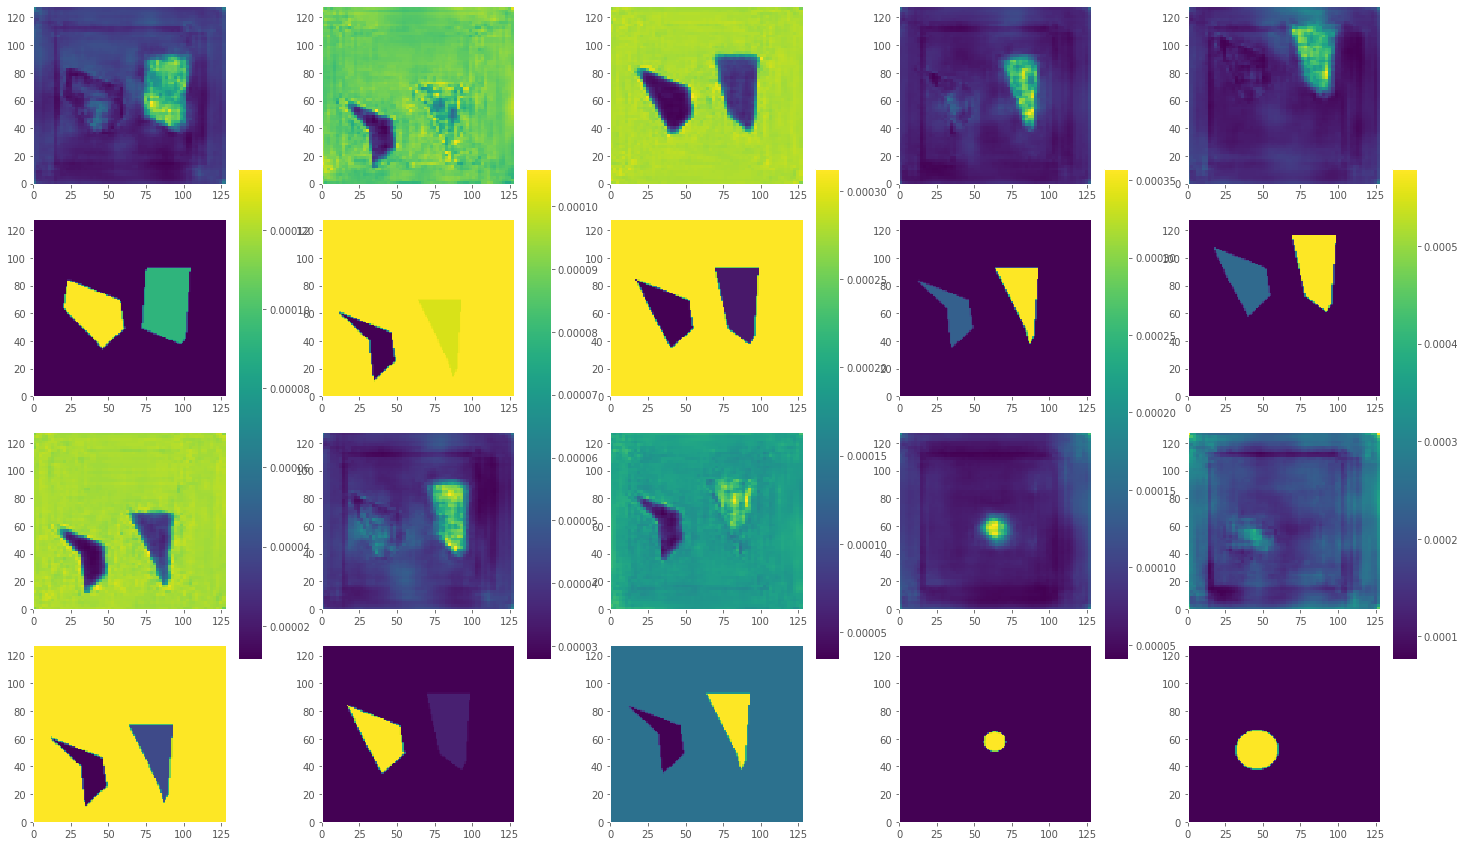

In [ ]:
preds_val1=preds_val[1]
import matplotlib.pyplot as plt
diff=y2_max-y2_min

fig, axs = plt.subplots(4, 5)
fig.set_figheight(15)
fig.set_figwidth(25)
n=0
N=70
for col in range(5):
    for row in range(4):
        ax = axs[row, col]
        if (n%2) ==0:
          pcm = ax.pcolormesh( (preds_val1[N,:,:,0]*diff+y2_min)* (col + 1),
                            cmap='viridis')
        else:
          pcm = ax.pcolormesh( (y2_test[N,:,:]*diff+y2_min)* (col + 1),
                            cmap='viridis')
          N=N+1
        n=n+1
    fig.colorbar(pcm, ax=axs[:, col], shrink=0.6)
plt.show()



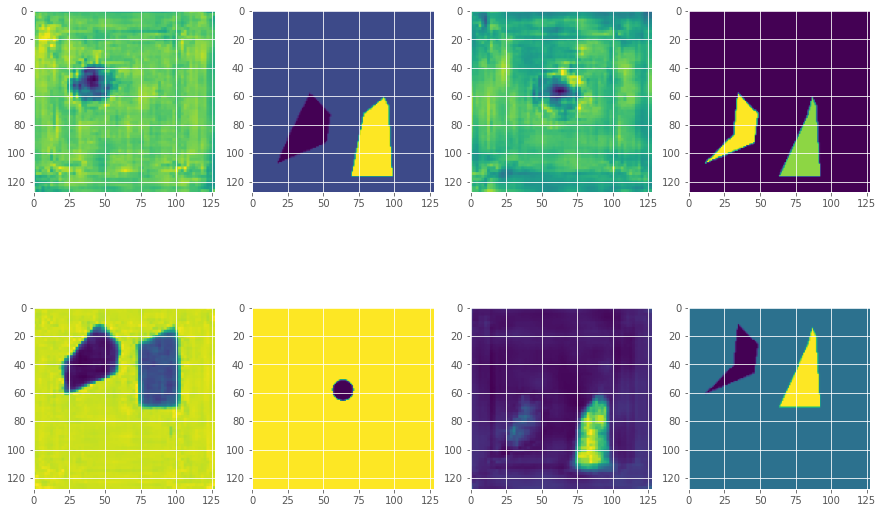

In [ ]:
f, axarr = plt.subplots(2,4)

f.set_figheight(10)
f.set_figwidth(15)
plt.colorbar
a1=axarr[0,0].imshow(preds_val1[10,:,:,0]*diff+y2_min)
a2=axarr[0,1].imshow(y2_valid[10,:,:]*diff+y2_min)

a3=axarr[0,2].imshow(preds_val1[20,:,:,0]*diff+y2_min)
a4=axarr[0,3].imshow(y2_valid[20,:,:]*diff+y2_min)

a5=axarr[1,0].imshow(preds_val1[34,:,:,0]*diff+y2_min)
a6=axarr[1,1].imshow(y2_valid[34,:,:]*diff+y2_min)

a7=axarr[1,2].imshow(preds_val1[44,:,:,0]*diff+y2_min)
a8=axarr[1,3].imshow(y2_valid[44,:,:]*diff+y2_min)
#plt.colorbar(a8)

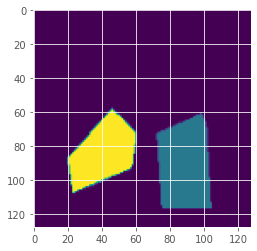

In [ ]:
plt.imshow(y2_valid[22,:,:])